### Testing generalization to eval dataset (transform_coltrane_2021_07_28_1.h5)

In [11]:
import os
import logging
# Send logging outputs to stdout (comment this out if preferred)
# logger = logging.getLogger()
# logger.setLevel(logging.INFO)

# Change this to egl or glfw if available
os.environ["MUJOCO_GL"] = "glfw"

from track_mjx.agent import checkpointing
from track_mjx.analysis import rollout, render, utils
from track_mjx.environment import wrappers
from typing import Dict, Callable
import numpy as np
import jax
from brax.envs.base import Env
from track_mjx.environment.walker.rodent import Rodent
from track_mjx.environment.walker.fly import Fly
from brax import envs
from typing import Dict, Callable
import hydra
import logging
from track_mjx.environment.task.reward import RewardConfig
from jax import numpy as jnp

from track_mjx.environment.task.multi_clip_tracking import MultiClipTracking
from track_mjx.environment.task.single_clip_tracking import SingleClipTracking
from track_mjx.environment import wrappers
from track_mjx.io import load


from omegaconf import DictConfig
from pathlib import Path

# don't preallocate jax memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"


In [12]:
eval_data_path = "/Users/charleszhang/GitHub/stac-mjx/transform_coltrane_2021_07_28_1.h5"

# replace with your checkpoint path
ckpt_path = "/Users/charleszhang/GitHub/track-mjx/model_checkpoints/ademamix_64"  
# Load config from checkpoint 
ckpt = checkpointing.load_checkpoint_for_eval(ckpt_path)

cfg = ckpt["cfg"]

# make some changes to the config
# replace with absolute path to your data
# -- your notebook may not have access to the same relative path
cfg.data_path = "/Users/charleszhang/GitHub/track-mjx/data/transform_snips.h5"
cfg.train_setup.checkpoint_to_restore = ckpt_path

In [13]:
tmp = load.make_singleclip_data(eval_data_path)
print(tmp.position.shape)
del tmp

(540000, 3)


In [14]:
n_frames_per_clip=2000
inference_fn = checkpointing.load_inference_fn(cfg, ckpt["policy"])
reference_clip = load.make_multiclip_data(eval_data_path, n_frames_per_clip=n_frames_per_clip)
reference_clip.position.shape

(270, 2000, 3)

create env with test set reference clips

In [15]:
envs.register_environment("rodent_multi_clip", MultiClipTracking)

env_args = cfg["env_config"]["env_args"]
env_rewards = cfg["env_config"]["reward_weights"]
walker_config = cfg["walker_config"]
traj_config = cfg["reference_config"]

walker = Rodent(**walker_config)

reward_config = RewardConfig(**env_rewards)
# Automatically match dict keys and func needs
env = envs.get_environment(
    env_name="rodent_multi_clip",
    reference_clip=reference_clip,
    walker=walker,
    reward_config=reward_config,
    **env_args,
    **traj_config,
)

env._steps_for_cur_frame: 2.0


/Users/charleszhang/miniforge3/envs/rl/lib/python3.11/site-packages/brax/io/mjcf.py:344: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  link = jax.tree_map(lambda x: x[1:].copy(), link)
/Users/charleszhang/miniforge3/envs/rl/lib/python3.11/site-packages/brax/io/mjcf.py:374: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  motion = jax.tree_map(lambda *x: np.concatenate(x), *motions)
/Users/charleszhang/miniforge3/envs/rl/lib/python3.11/site-packages/brax/io/mjcf.py:378: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  limit = jax.tree_map(lambda *x: np.concatenate(x), *limits)
/Users/charleszhang/miniforge3/envs/rl/lib/python3.11/site-packages/brax/io/mjcf.py:414: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (j

In [16]:
rollout_env = wrappers.RenderRolloutWrapperMulticlipTracking(env)

In [17]:
# vmap env.step and env.reset
jit_vmap_step = jax.jit(jax.vmap(rollout_env.step))
jit_vmap_reset = jax.jit(jax.vmap(rollout_env.reset))


In [18]:
# vmap wrapper and auto align wrapper
align_vmap_env = wrappers.AutoAlignWrapperTracking(
        wrappers.RenderRolloutVmapWrapper(rollout_env)
    )
align_reset = align_vmap_env.reset 
align_step = align_vmap_env.step

In [19]:
# vmap wrapper and auto align wrapper
autoreset_env = wrappers.AutoResetWrapperTracking(
        wrappers.RenderRolloutVmapWrapper(rollout_env)
    )
autoreset_reset = autoreset_env.reset 
autoreset_step = autoreset_env.step

In [20]:
# JIT-compile the necessary functions
jit_inference_fn = jax.jit(jax.vmap(inference_fn))
# jit_reset = jax.jit(rollout_env.reset)
# jit_step = jax.jit(rollout_env.step)
num_envs = 10
key_envs = jax.random.split(jax.random.PRNGKey(0), num_envs)
key_envs.shape

(10, 2)

### transform data to multiclip, then initialize to multiclip with a long clip length (5000)

In [12]:
# debugging -- direct vmapping renderrolloutwrapper
num_steps = (
    int(n_frames_per_clip * env._steps_for_cur_frame) - 1
) 
clip_idxs = jnp.arange(0, num_envs)
init_states = jit_vmap_reset(key_envs, clip_idx=clip_idxs)
print(init_states.pipeline_state.qpos.shape)
# debugging
rng_policy = jax.random.split(jax.random.PRNGKey(1), num_envs)
ctrl, extras = jit_inference_fn(init_states.obs, rng_policy)
next_state = jit_vmap_step(init_states, ctrl)
print(next_state.pipeline_state.qpos.shape)

(10, 74)

In [14]:
# debugging -- autoreset wrapper
num_steps = (
    int(n_frames_per_clip * env._steps_for_cur_frame) - 1
) 
clip_idxs = jnp.arange(0, num_envs)
init_states = autoreset_reset(key_envs)
print(init_states.pipeline_state.qpos.shape)

# debugging -- autoreset wrapper
rng_policy = jax.random.split(jax.random.PRNGKey(1), num_envs)
ctrl, extras = jit_inference_fn(init_states.obs, rng_policy)
state = autoreset_step(init_states, ctrl)
print(state.pipeline_state.qpos.shape)

(10, 74)
(10, 74)


In [11]:
# debugging -- autoalign wrapper
num_steps = (
    int(n_frames_per_clip * env._steps_for_cur_frame) - 1
) 
clip_idxs = jnp.arange(0, num_envs)
init_states = align_reset(key_envs)
print(init_states.pipeline_state.qpos.shape)

# debugging -- autoalign wrapper
rng_policy = jax.random.split(jax.random.PRNGKey(1), num_envs)
ctrl, extras = jit_inference_fn(init_states.obs, rng_policy)
state = align_step(init_states, ctrl)
print(state.pipeline_state.qpos.shape)

(10, 74)
stepped
(10, 74) (10, 73)
(10, 74) (10, 73)
(10, 74)


In [21]:
jit_align_reset = jax.jit(align_reset)
jit_align_step = jax.jit(align_step)
jit_autoreset_reset = jax.jit(autoreset_reset)
jit_autoreset_step = jax.jit(autoreset_step)


In [23]:
init_states = jit_autoreset_reset(key_envs)

In [25]:
# debugging -- autoreset wrapper
num_steps = (
    int(n_frames_per_clip * env._steps_for_cur_frame) - 1
) 

rollouts = [init_states]
state = init_states
activations = []
rng_policy = jax.random.split(jax.random.PRNGKey(1), num_envs)

for i in range(num_steps):
    print(i)
    ctrl, extras = jit_inference_fn(state.obs, rng_policy)
    activations.append(extras["activations"])
    state = jit_autoreset_step(state, ctrl)
    rollouts.append(state)

0
1


2025-03-19 12:22:43.731597: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


: 

In [ ]:
# debugging -- autoalign wrapper

num_steps = (
    int(n_frames_per_clip * env._steps_for_cur_frame) - 1
) 

rollouts = [init_states]
state = init_states
activations = []
rng_policy = jax.random.split(jax.random.PRNGKey(1), num_envs)

for i in range(num_steps):
    print(i)
    ctrl, extras = jit_inference_fn(state.obs, rng_policy)
    activations.append(extras["activations"])
    state = jit_autoreset_step(state, ctrl)
    rollouts.append(state)

In [2]:
a = jnp.ones((100, 1))
b = jnp.ones((100, 2))
c = jnp.ones((100, 3))
jnp.concatenate((a, b, c), axis=1).shape

NameError: name 'jnp' is not defined

### Function that takes in a vmapped env and scans through them with a different starting frame for each one

In [8]:
# JIT-compile the necessary functions
jit_inference_fn = jax.jit(jax.vmap(inference_fn))
jit_reset = jax.jit(rollout_env.reset)
jit_step = jax.jit(rollout_env.step)
vmap_slice = jax.vmap(slice_arrays, in_axes=(None, 0, None))

rollout_length = 2000

def rollout_vmapped_env(start_frame_arr, key, n_envs: int):
    _, reset_rng, scan_rng = jax.random.split(key, 3)
    
    scan_rng_arr = jax.random.split(scan_rng, n_envs)[:, 1]
    reset_rng = jax.random.split(reset_rng, n_envs)[:, 1]
    init_state = jit_reset(reset_rng, start_frame=start_frame_arr)

    num_steps = (
        int(rollout_length * env._steps_for_cur_frame) - 1
    )
    
    def _step_fn(carry, _):
        state, scan_rng_arr = carry
        _, scan_rng_arr = jax.vmap(jax.random.split)(scan_rng_arr)[:, 1]
        ctrl, extras = jit_inference_fn(state.obs, scan_rng_arr)
        next_state = jit_step(state, ctrl)
        return (next_state, scan_rng_arr), (next_state, ctrl, extras["activations"])

    # Run rollout
    init_carry = (init_state, scan_rng_arr)
    (final_state, _), (states, ctrls, activations) = jax.lax.scan(
        _step_fn, init_carry, None, length=num_steps
    )
    
    def prepend(element, arr):
        # Scalar elements shouldn't be modified
        if arr.ndim == 0:
            return arr

        return jnp.concatenate([element[None], arr])

    rollout_states = jax.tree.map(prepend, init_state, states)

    # Get metrics
    rollout_metrics = {}
    for rollout_metric in cfg.logging_config.rollout_metrics:
        rollout_metrics[f"{rollout_metric}s"] = jax.vmap(
            lambda s: s.metrics[rollout_metric]
        )(rollout_states)

    reward = jax.vmap(
        lambda s: s.reward
    )(rollout_states)
    
    # Collect qposes from states
    qposes_rollout = jax.vmap(lambda s: s.pipeline_state.qpos)(rollout_states)
    
    ref_traj = vmap_slice(
        reference_clip,
        start_frame_arr,
        rollout_length
    )

    qposes_ref = jnp.repeat(
        jnp.concatenate([
            ref_traj.position, 
            ref_traj.quaternion, 
            ref_traj.joints
        ], axis=2),
        int(env._steps_for_cur_frame),
        axis=1,
    )

    return {
        "reward": reward,
        "rollout_metrics": rollout_metrics,
        "observations": jax.vmap(lambda s: s.obs)(rollout_states),
        "ctrl": ctrls,
        "activations": activations,
        "qposes_ref": qposes_ref,
        "qposes_rollout": qposes_rollout,
        "info": jax.vmap(lambda s: s.info)(rollout_states),
    }

In [18]:
# jit_generate_rollout_fn = jax.jit(rollout_vmapped_env)
# vmap_generate_rollout_fn = jax.vmap(generate_rollout_fn_continuous)

keys = jax.random.split(jax.random.PRNGKey(0), 5)
keys.shape

(5, 2)

In [21]:
keys[:, 1].shape

(5,)

In [9]:
# Make array of starting frames to run using the vmapped function
arr = jnp.arange(start=0, stop=10000, step=rollout_length)

In [10]:
rollout = rollout_vmapped_env(arr, jax.random.PRNGKey(0), arr.shape[0])

(5,)


TypeError: vmap() got an unexpected keyword argument 'in_axes'

In [11]:
vmap_rollout["reward"].shape

(5, 4000)

set up reference qpos and save to the rollout dict

In [37]:
# Reference and rollout qposes
reference_clip = rollout_env._get_reference_clip(
    jit_reset(jax.random.PRNGKey(0)).info
)

vmap_slice = jax.vmap(slice_arrays, in_axes=(None, 0, None))

    

(5, 2000, 3)

In [53]:
ref_traj = vmap_slice(
    reference_clip,
    arr,
    rollout_length
    )

qposes_ref = jnp.repeat(
        jnp.concatenate([
            ref_traj.position, 
            ref_traj.quaternion, 
            ref_traj.joints
        ], axis=2),
        int(env._steps_for_cur_frame),
        axis=1,
    )

In [55]:
qposes_ref.shape

(5, 4000, 74)

In [56]:
vmap_rollout["qposes_ref"] = qposes_ref

construct single rollout dict to render 

In [57]:
rollout = {
    "qposes_ref": vmap_rollout["qposes_ref"][0],
    "qposes_rollout": vmap_rollout["qposes_rollout"][0]
}

In [58]:
frames, realtime_framerate = render.render_rollout(cfg, rollout)
render.display_video(frames, framerate=realtime_framerate)

MuJoCo Rendering...


100%|██████████| 4000/4000 [00:50<00:00, 79.58it/s]


plot reward over time for a 2000 (40 second) continuous rollout

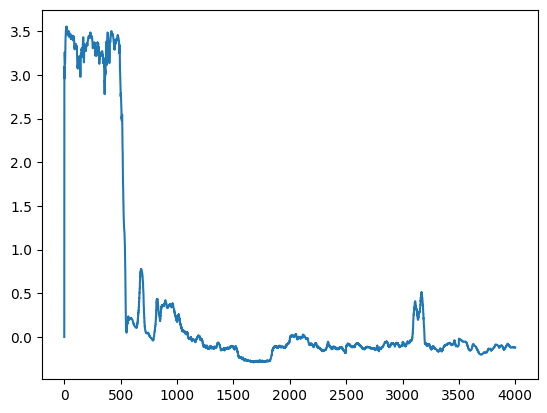

In [59]:
from matplotlib import pyplot as plt

plt.plot(vmap_rollout["reward"][0])